In [1]:
import nest_asyncio
nest_asyncio.apply()
import multiprocessing
multiprocessing.set_start_method("fork")
import pandas as pd
import stan
import numpy as np
from scipy.stats import pearsonr

from scipy.special import expit
import matplotlib.pyplot as plt
import arviz as az

# Emma notes (8/22):

In general, let's build complexity iteratively. Start by getting reasonable results without worrying about ICAR prior/smoothing. Then use standard ICAR prior (with weight 0.5). Then use full CAR (maybe). Data generation code is reviewed + model without proper CAR prior is reviewed. Another thing it might be nice to implement at some point is using the information about where the annotated images are (i.e., what Census tracts). Could incorporate this as a multinomial (potentially?) 

Model with simple L2 smoothing (or no smoothing at all - stan_code_with_weighted_ICAR_prior):

1. Consistently recovers parameters for realistic parameter settings (with no smoothing)
2. Reviewed Stan code and looks good. 
3. ALso implemented L2 regularization for adjacent Census tracts. This isn't actually the "proper" way to do it, but might be useful on real data. Haven't tested how this performs. 

Model wih full CAR prior (stan_code_proper_car_prior):

1. Haven't reviewed this or verified it recovers correct params (recently; I think I did a while ago). When you do review, don't need to re-review all the Bayesian conditioning math; it should be pretty similar to the old code. 


In [2]:
# Stan code with CAR prior seems to work but hasn't been reviewed. 
# CAR prior is https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html
stan_code_proper_car_prior = '''
functions {
  /**
  * Return the log probability of a proper conditional autoregressive (CAR) prior 
  * with a sparse representation for the adjacency matrix
  *
  * @param phi Vector containing the parameters with a CAR prior
  * @param tau Precision parameter for the CAR prior (real)
  * @param alpha Dependence (usually spatial) parameter for the CAR prior (real)
  * @param W_sparse Sparse representation of adjacency matrix (int array)
  * @param n Length of phi (int)
  * @param W_n Number of adjacent pairs (int)
  * @param D_sparse Number of neighbors for each location (vector)
  * @param lambda Eigenvalues of D^{-1/2}*W*D^{-1/2} (vector)
  *
  * @return Log probability density of CAR prior up to additive constant
  */
  real sparse_car_lpdf(vector phi, real tau, real alpha,
                       array[,] int W_sparse, vector D_sparse, vector lambda,
                       int n, int W_n) {
    row_vector[n] phit_D; // phi' * D
    row_vector[n] phit_W; // phi' * W
    vector[n] ldet_terms;
    
    phit_D = (phi .* D_sparse)';
    phit_W = rep_row_vector(0, n);
    for (i in 1 : W_n) {
      phit_W[W_sparse[i, 1]] = phit_W[W_sparse[i, 1]] + phi[W_sparse[i, 2]];
      phit_W[W_sparse[i, 2]] = phit_W[W_sparse[i, 2]] + phi[W_sparse[i, 1]];
    }
    
    for (i in 1 : n) {
      ldet_terms[i] = log1m(alpha * lambda[i]);
    }
    return 0.5
           * (n * log(tau) + sum(ldet_terms)
              - tau * (phit_D * phi - alpha * (phit_W * phi)));
  }
}

data {
  int<lower=0> N;
  int<lower=0> N_edges;
  matrix<lower=0, upper=1>[N, N] W; // adjacency matrix
  int W_n; // number of adjacent region pairs
  array[N] int<lower=0> n_images; 
  array[N] int<lower=0> n_classified_positive; 

  //annotation sample. 
  int n_annotated_classified_negative;
  int n_annotated_classified_positive;
  int n_annotated_classified_negative_true_positive;
  int n_annotated_classified_positive_true_positive;  
}
transformed data {
  array[W_n, 2] int W_sparse; // adjacency pairs
  vector[N] D_sparse; // diagonal of D (number of neigbors for each site)
  vector[N] lambda; // eigenvalues of invsqrtD * W * invsqrtD
  
  {
    // generate sparse representation for W
    int counter;
    counter = 1;
    // loop over upper triangular part of W to identify neighbor pairs
    for (i in 1 : (N - 1)) {
      for (j in (i + 1) : N) {
        if (W[i, j] == 1) {
          W_sparse[counter, 1] = i;
          W_sparse[counter, 2] = j;
          counter = counter + 1;
        }
      }
    }
  }
  for (i in 1 : N) {
    D_sparse[i] = sum(W[i]);
  }
  {
    vector[N] invsqrtD;
    for (i in 1 : N) {
      invsqrtD[i] = 1 / sqrt(D_sparse[i]);
    }
    lambda = eigenvalues_sym(quad_form(W, diag_matrix(invsqrtD)));
  }
}

parameters {
  vector[N] phi;
  real<lower=0> tau;
  real<lower=0, upper=1> alpha;
  real <upper=0>phi_offset; // you may not want to place this constraint but it helps convergence with small numbers of samples
  real<lower=0, upper=1> p_y_1_given_y_hat_1; 
  real<lower=0, upper=1> p_y_1_given_y_hat_0;
}
transformed parameters {
    vector[N] p_y = inv_logit(phi + phi_offset);
    //real predicted_overall_p_y = sum(n_images .* p_y) / sum(n_images);
    real empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images);
    real p_y_hat_1_given_y_1 = empirical_p_yhat * p_y_1_given_y_hat_1 / (empirical_p_yhat * p_y_1_given_y_hat_1 + (1 - empirical_p_yhat) * p_y_1_given_y_hat_0);
    real p_y_hat_1_given_y_0 = empirical_p_yhat * (1 - p_y_1_given_y_hat_1) / (empirical_p_yhat * (1 - p_y_1_given_y_hat_1) + (1 - empirical_p_yhat) * (1 - p_y_1_given_y_hat_0));
}
model {
  n_annotated_classified_negative_true_positive ~ binomial(n_annotated_classified_negative , p_y_1_given_y_hat_0);
  n_annotated_classified_positive_true_positive ~ binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1);
  tau ~ gamma(2, 2);
  phi ~ sparse_car(tau, alpha, W_sparse, D_sparse, lambda, N, W_n);
  phi_offset ~ normal(-4, 0.5);
  n_classified_positive ~ binomial(n_images, p_y .* p_y_hat_1_given_y_1 + (1 - p_y) .* p_y_hat_1_given_y_0);
}
'''

# Stan code below works and has been reviewed but does not implement a proper ICAR prior. Set variable use_ICAR_prior to 0 if you don't want to use one at all. 
# I think it might also be principled to set the ICAR prior weight to 0.5, https://mc-stan.org/users/documentation/case-studies/icar_stan.html. 
stan_code_with_weighted_ICAR_prior = '''
data {
  int<lower=0> N; // number of Census tracts. 
  int<lower=0> N_edges; // number of edges in the graph (i.e. number of pairs of adjacent Census tracts). 
  array[N_edges] int<lower=1, upper=N> node1; // node1[i] adjacent to node2[i]
  array[N_edges] int<lower=1, upper=N> node2; // and node1[i] < node2[i]
  array[N] int<lower=0> n_images; // vector with one entry per Census tract of the number of images in that tract. 
  array[N] int<lower=0> n_classified_positive; // vector with one entry per Census tract of number of images classified positive. 
  int<lower=0,upper=1> use_ICAR_prior; // 1 if you want to use ICAR prior, 0 if you don't. ICAR prior basically smooths the data. 
  real <lower=0> ICAR_prior_weight; // weight of ICAR prior.

  //annotation sample. 
  int n_annotated_classified_negative;
  int n_annotated_classified_positive;
  int n_annotated_classified_negative_true_positive;
  int n_annotated_classified_positive_true_positive;  
}
parameters {
  vector[N] phi;
  real<upper=0> phi_offset; // this is the mean from which phis are drawn. Upper bound at 0 to rule out bad modes and set prior that true positives are rare. 
  ordered[2] logit_p_y_1_given_y_hat; // ordered to impose the constraint that p_y_1_given_y_hat_0 < p_y_1_given_y_hat_1.
}
transformed parameters {
    real p_y_1_given_y_hat_0 = inv_logit(logit_p_y_1_given_y_hat[1]);
    real p_y_1_given_y_hat_1 = inv_logit(logit_p_y_1_given_y_hat[2]);
    vector[N] p_y = inv_logit(phi);
    real empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images);
    real p_y_hat_1_given_y_1 = empirical_p_yhat * p_y_1_given_y_hat_1 / (empirical_p_yhat * p_y_1_given_y_hat_1 + (1 - empirical_p_yhat) * p_y_1_given_y_hat_0);
    real p_y_hat_1_given_y_0 = empirical_p_yhat * (1 - p_y_1_given_y_hat_1) / (empirical_p_yhat * (1 - p_y_1_given_y_hat_1) + (1 - empirical_p_yhat) * (1 - p_y_1_given_y_hat_0));
}
model {
  // You can't just scale ICAR priors by random numbers; the only principled value for ICAR_prior_weight is 0.5. 
  // https://stats.stackexchange.com/questions/333258/strength-parameter-in-icar-spatial-model
  // still, there's no computational reason you can't use another value. 
  if (use_ICAR_prior == 1) {
    target += -ICAR_prior_weight * dot_self(phi[node1] - phi[node2]);
  }

  // model the results on the annotation set. 
  n_annotated_classified_negative_true_positive ~ binomial(n_annotated_classified_negative, p_y_1_given_y_hat_0);
  n_annotated_classified_positive_true_positive ~ binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1);
  
  // model the results by Census tract. 
  phi_offset ~ normal(0, 2);
  phi ~ normal(phi_offset, 1); 
  n_classified_positive ~ binomial(n_images, p_y .* p_y_hat_1_given_y_1 + (1 - p_y) .* p_y_hat_1_given_y_0);
}
'''

stan_model_uniform_p_y = '''
data {
  int<lower=0> N; // number of Census tracts. 
  array[N] int<lower=0> n_images; // vector with one entry per Census tract of the number of images in that tract. 
  array[N] int<lower=0> n_classified_positive; // vector with one entry per Census tract of number of images classified positive. 

  //annotation sample. 
  int n_annotated_classified_negative;
  int n_annotated_classified_positive;
  int n_annotated_classified_negative_true_positive;
  int n_annotated_classified_positive_true_positive;  
}
parameters {
  vector<lower=0, upper=1>[N] p_y; // probability of a positive image in each Census tract.
  ordered[2] logit_p_y_1_given_y_hat; // ordered to impose the constraint that p_y_1_given_y_hat_0 < p_y_1_given_y_hat_1.
}
transformed parameters {
    real p_y_1_given_y_hat_0 = inv_logit(logit_p_y_1_given_y_hat[1]);
    real p_y_1_given_y_hat_1 = inv_logit(logit_p_y_1_given_y_hat[2]);
    real empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images);
    real p_y_hat_1_given_y_1 = empirical_p_yhat * p_y_1_given_y_hat_1 / (empirical_p_yhat * p_y_1_given_y_hat_1 + (1 - empirical_p_yhat) * p_y_1_given_y_hat_0);
    real p_y_hat_1_given_y_0 = empirical_p_yhat * (1 - p_y_1_given_y_hat_1) / (empirical_p_yhat * (1 - p_y_1_given_y_hat_1) + (1 - empirical_p_yhat) * (1 - p_y_1_given_y_hat_0));
}
model {
  // model the results on the annotation set. 
  n_annotated_classified_negative_true_positive ~ binomial(n_annotated_classified_negative, p_y_1_given_y_hat_0);
  n_annotated_classified_positive_true_positive ~ binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1);
  
  // model the results by Census tract. 
  p_y ~ uniform(0, 1);
  n_classified_positive ~ binomial(n_images, p_y .* p_y_hat_1_given_y_1 + (1 - p_y) .* p_y_hat_1_given_y_0);
}
'''

In [3]:
def read_real_data(single_compartment_for_debugging=False):
    df = pd.read_csv("flooding_ct_dataset.csv")
    df[['total_images','positive_images']] = df[['total_images','positive_images']].astype(int).fillna(0)
    N = len(df)
    n_images = df['total_images'].values
    n_classified_positive = df['positive_images'].values 

    # Generate adjacency matrix and neighborhood structure
    node1 = []
    node2 = []

    N_ANNOTATED_CLASSIFIED_NEGATIVE = 500
    N_ANNOTATED_CLASSIFIED_POSITIVE = 500
    N_ANNOTATED_CLASSIFIED_NEGATIVE_TRUE_POSITIVE = 3
    N_ANNOTATED_CLASSIFIED_POSITIVE_TRUE_POSITIVE = 329


    if single_compartment_for_debugging:
        N = 1
        n_images = [sum(n_images)]
        n_classified_positive = [sum(n_classified_positive)]

    return {'observed_data': {
                'N': N, 'N_edges': len(node1), 'node1': node1, 'node2': node2, 
                'n_images': n_images,
                'n_classified_positive': n_classified_positive, 
                'n_annotated_classified_negative': N_ANNOTATED_CLASSIFIED_NEGATIVE,
                'n_annotated_classified_positive': N_ANNOTATED_CLASSIFIED_POSITIVE,
                'n_annotated_classified_negative_true_positive': N_ANNOTATED_CLASSIFIED_NEGATIVE_TRUE_POSITIVE,
                'n_annotated_classified_positive_true_positive': N_ANNOTATED_CLASSIFIED_POSITIVE_TRUE_POSITIVE
            }
            }

def generate_simulated_data(N, images_per_location, 
                            n_annotated_classified_negative, 
                            n_annotated_classified_positive, 
                            icar_prior_setting):
    """
    Generate simulated data for the model.
    """    
    node1 = []
    node2 = []
    for i in range(N):
        for j in range(i+1, N):
            if np.random.rand() < 0.1:
                node1.append(i + 1) # one indexing for Stan. 
                node2.append(j + 1)
    phi_offset = random.random() * -3 - 1 # mean of phi.

    # these only matter for CAR model. https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html
    D = np.zeros((N, N))
    W = np.zeros((N, N))
    for i in range(len(node1)):
        D[node1[i] - 1, node1[i] - 1] += 1
        D[node2[i] - 1, node2[i] - 1] += 1
        W[node1[i] - 1, node2[i] - 1] = 1
        W[node2[i] - 1, node1[i] - 1] = 1
    B = np.linalg.inv(D) @ W
    tau = np.random.gamma(scale=0.2, shape=2)
    alpha = np.random.random()
    sigma = np.linalg.inv(tau * D @ (np.eye(N) - alpha * B))
    if icar_prior_setting != 'none':    
        phi = np.random.multivariate_normal(mean=np.zeros(N), cov=sigma)
    else:
        phi = np.random.normal(loc=0, size=N) # this uses no icar prior, just draws everything independently. 
    p_Y = expit(phi + phi_offset)
    n_images = np.random.poisson(images_per_location, N)
    p_y_hat_1_given_y_1 = random.random() * 0.5 + 0.2
    p_y_hat_1_given_y_0 = random.random() * 0.01 + 0.01

    n_classified_positive = []
    n_true_positive = []
    for i in range(N):
        n_true_positive.append(np.random.binomial(n_images[i], p_Y[i]))
        n_classified_positive.append(np.random.binomial(n_true_positive[-1], p_y_hat_1_given_y_1) + 
                                    np.random.binomial(n_images[i] - n_true_positive[-1], p_y_hat_1_given_y_0))
    empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images)
    empirical_p_y = sum(n_true_positive) * 1.0 / sum(n_images)
    p_y_1_given_y_hat_1 = p_y_hat_1_given_y_1 * empirical_p_y / empirical_p_yhat
    p_y_1_given_y_hat_0 = (1 - p_y_hat_1_given_y_1) * empirical_p_y / (1 - empirical_p_yhat)
    print("empirical_p_y", empirical_p_y)
    print("empirical_p_yhat", empirical_p_yhat)
    print("p_y_hat_1_given_y_1", p_y_hat_1_given_y_1)
    print("p_y_hat_1_given_y_0", p_y_hat_1_given_y_0)
    print("p_y_1_given_y_hat_1", p_y_1_given_y_hat_1)
    print("p_y_1_given_y_hat_0", p_y_1_given_y_hat_0)
                     
    n_annotated_classified_negative_true_positive = np.random.binomial(n_annotated_classified_negative, p_y_1_given_y_hat_0)
    n_annotated_classified_positive_true_positive = np.random.binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1)
    print("number of annotated classified negative which were positive: %i/%i" % (n_annotated_classified_negative_true_positive, n_annotated_classified_negative))
    print("number of annotated classified positive which were positive: %i/%i" % (n_annotated_classified_positive_true_positive, n_annotated_classified_positive))
    

    return {'observed_data':{'N':N, 'N_edges':len(node1), 'node1':node1, 'node2':node2, 
                             'n_images':n_images, 'n_classified_positive':n_classified_positive, 
                             'n_annotated_classified_negative':n_annotated_classified_negative,
                                'n_annotated_classified_positive':n_annotated_classified_positive,
                                'n_annotated_classified_negative_true_positive':n_annotated_classified_negative_true_positive,
                                'n_annotated_classified_positive_true_positive':n_annotated_classified_positive_true_positive},

            'parameters':{'phi':phi, 'phi_offset':phi_offset, 
                          'p_y_1_given_y_hat_1':p_y_1_given_y_hat_1,
                            'p_y_1_given_y_hat_0':p_y_1_given_y_hat_0, 
                            'p_y_hat_1_given_y_1':p_y_hat_1_given_y_1,
                            'p_y_hat_1_given_y_0':p_y_hat_1_given_y_0, 
                            'p_Y':p_Y, 
                            'tau':tau, 'alpha':alpha, 'sigma':sigma}}

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/18000)
Sampling:   0% (2/18000)
Sampling:   0% (3/18000)
Sampling:   0% (4/18000)
Sampling:   1% (103/18000)
Sampling:   1% (203/18000)
Sampling:   2% (302/18000)
Sampling:   2% (401/18000)
Sampling:   3% (501/18000)
Sampling:   3% (601/18000)
Sampling:   4% (700/18000)
Sampling:   4% (800/18000)
Sampling:   5% (900/18000)
Sampling:   6% (1000/18000)
Sampling:   6% (1100/18000)
Sampling:   7% (1200/18000)
Sampling:   7% (1300/18000)
Sampling:   8% (1400/18000)
Sampling:   8% (1500/18000)
Sampling:   9% (1600/18000)
Sampling:   9% (1700/18000)
Sampling:  10% (1800/18000)
Sampling:  11% (1900/18000)
Sampling:  11% (2000/18000)
Sampling:  12% (2100/18000)
Sampling:  12% (2200/18000)
Sampling:  13% (2300/18000)
Sampling:  13% (2400/18000)
Sampling:  14% (2500/18000)
Sampling:  14% (2600/18000)
Sampling:  15% (2700/18000)
Sampling:  16% (2800/18000)
Sampling:  16% (2900/18000)
Sampling:  17% (3000/18000)
S

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.460  0.127   0.248    0.705      0.026    0.018   
p_y_hat_1_given_y_0  0.000  0.000   0.000    0.000      0.000    0.000   
phi_offset          -6.605  0.279  -7.121   -6.075      0.060    0.043   
p_y_1_given_y_hat_1  0.777  0.015   0.749    0.805      0.000    0.000   
p_y_1_given_y_hat_0  0.002  0.001   0.000    0.003      0.000    0.000   
...                    ...    ...     ...      ...        ...      ...   
p_y[2320]            0.002  0.003   0.000    0.006      0.000    0.000   
p_y[2321]            0.003  0.004   0.000    0.009      0.000    0.000   
p_y[2322]            0.001  0.001   0.000    0.003      0.000    0.000   
p_y[2323]            0.002  0.002   0.000    0.005      0.000    0.000   
p_y[2324]            0.004  0.005   0.000    0.011      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      22.0      51.0   1.13  
p_y_hat_1_giv

/var/folders/4f/8vch_0092bl25hybnd8617b80000gn/T/ipykernel_11663/1108121146.py:91: RuntimeWarning: invalid value encountered in divide
  empirical_p_yhat = data_to_use['observed_data']['n_classified_positive'] / data_to_use['observed_data']['n_images']


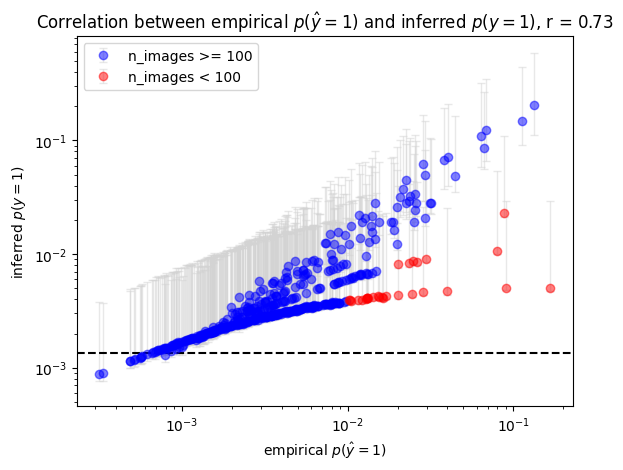

In [4]:
import random

icar_prior_setting = 'none'
use_simulated_data = False
assert icar_prior_setting in ['none', 'cheating', 'proper', 'just_model_p_y']
for i in range(1):
    NUM_WARMUP = 3000
    NUM_SAMPLES = 1500
    if use_simulated_data:
        N = 1000
        data_to_use = generate_simulated_data(N=N, 
                                                images_per_location=1000, 
                                                n_annotated_classified_negative=500, 
                                                n_annotated_classified_positive=500, 
                                                icar_prior_setting=icar_prior_setting)
    else:
        data_to_use = read_real_data(single_compartment_for_debugging=False)
    if icar_prior_setting == 'proper':
        raise Exception("Haven't verified that this model actually works! Need to review it / check on simulated data. No need to review the parts which are identical to the other model.")
        W = np.zeros((N, N))
        
        for i in range(len(simulated_data['observed_data']['node1'])):
            W[simulated_data['observed_data']['node1'][i] - 1, 
                                simulated_data['observed_data']['node2'][i] - 1] = 1
            W[simulated_data['observed_data']['node2'][i] - 1, 
                                simulated_data['observed_data']['node1'][i] - 1] = 1
        del simulated_data['observed_data']['node1']
        del simulated_data['observed_data']['node2']
        simulated_data['observed_data']['W'] = W
        simulated_data['observed_data']['W_n'] = int(W.sum() / 2)
        model = stan.build(stan_code_proper_car_prior, data=simulated_data['observed_data'])
    elif icar_prior_setting == 'cheating':
        data_to_use['observed_data']['use_ICAR_prior'] = 1
        data_to_use['observed_data']['ICAR_prior_weight'] = 0.5
        model = stan.build(stan_code_with_weighted_ICAR_prior, data=data_to_use['observed_data'])
    elif icar_prior_setting == 'none':
        data_to_use['observed_data']['use_ICAR_prior'] = 0
        data_to_use['observed_data']['ICAR_prior_weight'] = 0
        model = stan.build(stan_code_with_weighted_ICAR_prior, data=data_to_use['observed_data'])
    elif icar_prior_setting == 'just_model_p_y':
        del data_to_use['observed_data']['node1']
        del data_to_use['observed_data']['node2']
        del data_to_use['observed_data']['N_edges']
        model = stan.build(stan_model_uniform_p_y, data=data_to_use['observed_data'])
    else:
        raise ValueError("Invalid icar_prior_options", icar_prior_setting)
    fit = model.sample(num_chains=4, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)
    df = fit.to_frame()
    if icar_prior_setting == 'just_model_p_y':
        print(az.summary(fit, var_names=['p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
                                        'p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
                                        'empirical_p_yhat', 'p_y']))
    else:
        print(az.summary(fit, var_names=['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 'phi_offset', 
                                    'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
                                    'empirical_p_yhat', 'p_y']))
        
    if use_simulated_data:
        inferred_p_y = [df[f'p_y.{i}'].mean() for i in range(1, N + 1)]
        plt.scatter(data_to_use['parameters']['p_Y'], inferred_p_y)
        plt.title("True vs. inferred p_Y, r = %.2f" %
                pearsonr(data_to_use['parameters']['p_Y'], inferred_p_y)[0])
        max_val = max(max(data_to_use['parameters']['p_Y']), max(inferred_p_y))
        plt.xlabel("True p_Y")
        plt.ylabel("Inferred p_Y")
        plt.plot([0, max_val], [0, max_val], 'r--')
        plt.xlim([0, max_val])
        plt.ylim([0, max_val])
        plt.figure(figsize=[12, 3])


        if icar_prior_setting == 'proper':
            param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset', 'alpha', 'tau']
        elif icar_prior_setting == 'just_model_p_y':
            param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset']
        else:
            param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0']
        for k in param_names:
            plt.subplot(1, len(param_names), param_names.index(k) + 1)
            # histogram of posterior samples
            plt.hist(df[k], bins=50, density=True)
            plt.title(k)
            plt.axvline(data_to_use['parameters'][k], color='red')
        plt.show()
    else:
        empirical_p_yhat = data_to_use['observed_data']['n_classified_positive'] / data_to_use['observed_data']['n_images']
        print("Warning: %i of %i empirical p_yhat values are 0; these are being ignored" % (sum(np.isnan(empirical_p_yhat)), len(empirical_p_yhat)))
        inferred_p_y = np.array([df[f'p_y.{i}'].mean() for i in range(1, len(empirical_p_yhat) + 1)])
        inferred_p_y_CIs = [df[f'p_y.{i}'].quantile([0.025, 0.975]) for i in range(1, len(empirical_p_yhat) + 1)]
        n_images = data_to_use['observed_data']['n_images']
        # make errorbar plot
        image_cutoff = 100

        plt.errorbar(empirical_p_yhat[n_images >= image_cutoff], inferred_p_y[n_images >= image_cutoff], 
                    yerr=np.array(inferred_p_y_CIs)[n_images >= image_cutoff].T, fmt='o', 
                    color='blue', 
                    ecolor='lightgray', elinewidth=1, capsize=3, alpha=0.5, 
                    label="n_images >= %i" % image_cutoff)

        plt.errorbar(empirical_p_yhat[n_images < image_cutoff], inferred_p_y[n_images < image_cutoff], 
                    yerr=np.array(inferred_p_y_CIs)[n_images < image_cutoff].T, fmt='o', 
                    color='red', 
                    ecolor='lightgray', elinewidth=1, capsize=3, alpha=0.5, 
                    label="n_images < %i" % image_cutoff)
        plt.legend()

        # plot prior on p_y as vertical line. 
        phi_offset = df['phi_offset'].mean()
        plt.axhline(expit(phi_offset), color='black', linestyle='--')
        is_nan = np.isnan(empirical_p_yhat)
        plt.title("Correlation between empirical $p(\\hat y = 1)$ and inferred $p(y = 1)$, r = %.2f" % pearsonr(empirical_p_yhat[~is_nan], inferred_p_y[~is_nan])[0])
        plt.xlabel("empirical $p(\\hat y = 1)$")
        plt.ylabel("inferred $p(y = 1)$")
        # logarithmic axes
        plt.xscale('log')
        plt.yscale('log')




# Code below here is deprecated. 

In [ ]:
# Stan code below "works" but cheats on the ICAR prior. Set variable use_ICAR_prior to 0 if you don't want to use one at all.  
DEPRECATED_stan_code_cheating_ICAR_prior_with_soft_zero_constraint = '''
data {
  int<lower=0> N;
  int<lower=0> N_edges;
  array[N_edges] int<lower=1, upper=N> node1; // node1[i] adjacent to node2[i]
  array[N_edges] int<lower=1, upper=N> node2; // and node1[i] < node2[i]
  array[N] int<lower=0> n_images; 
  array[N] int<lower=0> n_classified_positive; 
  int<lower=0,upper=1> use_ICAR_prior; // 1 if you want to use ICAR prior, 0 if you don't. ICAR prior basically smooths the data. 
  real <lower=0> ICAR_prior_weight; // weight of ICAR prior.

  //annotation sample. 
  int n_annotated_classified_negative;
  int n_annotated_classified_positive;
  int n_annotated_classified_negative_true_positive;
  int n_annotated_classified_positive_true_positive;  
}
parameters {
  vector[N] phi;
  real phi_offset; 
  real<lower=0, upper=1> p_y_1_given_y_hat_1; 
  real<lower=0, upper=1> p_y_1_given_y_hat_0;
}
transformed parameters {
    vector[N] p_y = inv_logit(phi + phi_offset);
    //real predicted_overall_p_y = sum(n_images .* p_y) / sum(n_images);
    real empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images);
    real p_y_hat_1_given_y_1 = empirical_p_yhat * p_y_1_given_y_hat_1 / (empirical_p_yhat * p_y_1_given_y_hat_1 + (1 - empirical_p_yhat) * p_y_1_given_y_hat_0);
    real p_y_hat_1_given_y_0 = empirical_p_yhat * (1 - p_y_1_given_y_hat_1) / (empirical_p_yhat * (1 - p_y_1_given_y_hat_1) + (1 - empirical_p_yhat) * (1 - p_y_1_given_y_hat_0));
}
model {

  // You can't just scale ICAR priors by random numbers, so this is "cheating". Still, maybe a good sanity check. 
  // https://stats.stackexchange.com/questions/333258/strength-parameter-in-icar-spatial-model
  if (use_ICAR_prior == 1) {
    target += -ICAR_prior_weight * dot_self(phi[node1] - phi[node2]);
  }
  n_annotated_classified_negative_true_positive ~ binomial(n_annotated_classified_negative, p_y_1_given_y_hat_0);
  n_annotated_classified_positive_true_positive ~ binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1);
  
  // soft sum-to-zero constraint on phi,
  // equivalent to mean(phi) ~ normal(0,0.01)
  phi_offset ~ normal(0, 2);
  //sum(phi) ~ normal(0, 0.01 * N); // ZERO CENTERED.
  n_classified_positive ~ binomial(n_images, p_y .* p_y_hat_1_given_y_1 + (1 - p_y) .* p_y_hat_1_given_y_0);
}
'''
